In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from train_model import SegNet, ARMultiAnnDataset, collate_var, FNAME_RE
torch.manual_seed(0)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
from sklearn.metrics import jaccard_score

In [3]:
import numpy as np
import jax
import jax.numpy as jnp
import numpy as np
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

In [22]:
import torch
from torch.utils.data import DataLoader

# ─── helper: collate that keeps y_cons but ignores raw lists ────────────────
def collate_test(batch):
    xs, _, y_cons = zip(*batch)          # y_lists not needed for SegNet
    return torch.stack(xs), torch.stack(y_cons)

# ─── core routine ───────────────────────────────────────────────────────────
def predict_with_gt(ckpt_path : str,
                    data_dir  : str,
                    batch_size: int = 4,
                    device    : str = "cuda"  # or "cpu"
                   ) -> tuple[torch.Tensor, torch.Tensor]:

    ds = ARMultiAnnDataset(data_dir, ["TMQ"])          # TMQ only
    dl = DataLoader(ds, batch_size=batch_size, shuffle=False,
                    collate_fn=collate_test, pin_memory=(device=="cuda"))

    # load SegNet
    seg = SegNet().to(device).eval()
    seg.load_state_dict(torch.load(ckpt_path, map_location=device))

    preds, gts = [], []
    autocast = torch.amp.autocast
    with torch.no_grad(), autocast(device_type=device, dtype=torch.float16):
        for x_vars, y_cons in dl:
            x_vars = x_vars.to(device)
            logits = seg(x_vars)                 # (B,1,H,W)
            preds.append(torch.sigmoid(logits))  # fp16
            gts.append(y_cons.to(device))        # fp32

    PRED = torch.cat(preds, 0)                   # [N,1,H,W]
    GT   = torch.cat(gts, 0)                     # [N,1,H,W]
    return PRED, GT


In [23]:
pred, gt = predict_with_gt(
    ckpt_path = "/home/sbk29/data/github_AR/AR_detection/u-net/runs/arseg/segnet_final.pt"  ,
    data_dir  = "/home/sbk29/data/AR/test",
    batch_size= 4,
    device    = "cuda"
)

print("pred", pred.shape, pred.dtype, pred.device)
print("gt  ", gt.shape,   gt.dtype,   gt.device)


/tmp/ipykernel_1590872/1610774988.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  seg.load_state_dict(torch.load(ckpt_path, map_location=device))


pred torch.Size([16, 1, 768, 1152]) torch.float16 cuda:0
gt   torch.Size([16, 1, 768, 1152]) torch.float32 cuda:0


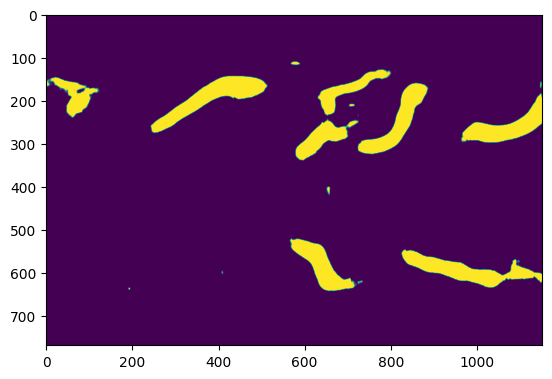

In [24]:
plt.imshow(pred[6,0,:,:].cpu())

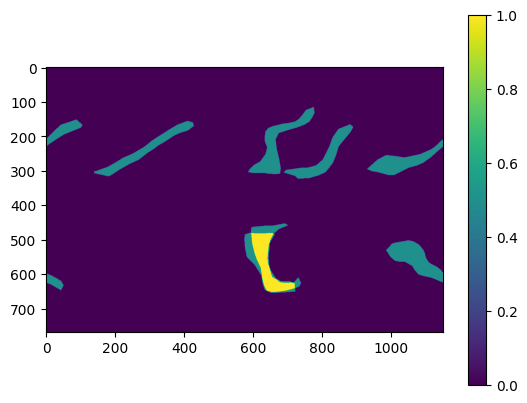

In [25]:
plt.imshow(gt[6,0,:,:].cpu())
plt.colorbar()

In [8]:
plt.imshow(p_hat[3,:,:]> 0.5)

NameError: name 'p_hat' is not defined

Now we will fit a Bayesian logistic regression to calibrate the probabilities

In [26]:
true_mask = np.array(gt[:,0,:,:].cpu()>0.3)  # Size : (B, 768, 1152)
score_whole = np.array(pred.cpu()) # Size : (B, 1, 768, 1152)

In [27]:
N,H,W = true_mask.shape

In [28]:
z_test = score_whole.reshape(-1)          # (N·H·W,)
y_test = true_mask.reshape(-1)          # same length

In [29]:


# 1) Send your data to the GPU
#    z: logits, shape (Npix,)
#    y: labels 0/1, same shape
z_flat = jnp.asarray(z_test.astype("float32"))
y_flat = jnp.asarray(y_test.astype("int32"))

# 2) Define the Platt‐scaling model
def platt_model(z, y=None):
    A = numpyro.sample("A", dist.Normal(0.0, 10.0))
    B = numpyro.sample("B", dist.Normal(0.0, 10.0))
    logits = A * z + B
    numpyro.sample("obs", dist.Bernoulli(logits=logits), obs=y)
        
# 3) Set up and run NUTS on the GPU
kernel = NUTS(platt_model, target_accept_prob=0.9)
mcmc   = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
rng_key = jax.random.PRNGKey(0)

mcmc.run(rng_key, z=z_flat, y=y_flat)
mcmc.print_summary()   # shows mean, sd, R-hat, ESS for A and B

# 4) Extract posterior samples of A, B
posterior = mcmc.get_samples()
A_draws   = posterior["A"]   # shape (1000,)
B_draws   = posterior["B"]

/tmp/ipykernel_1590872/2652090856.py:16: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc   = MCMC(kernel, num_warmup=1000, num_samples=1000, num_chains=2)
sample: 100%|██████████| 2000/2000 [00:14<00:00, 136.03it/s, 15 steps of size 2.15e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         A      4.08      0.00      4.08      4.07      4.08    701.44      1.00
         B     -3.48      0.00     -3.48     -3.48     -3.48    905.62      1.00

Number of divergences: 0


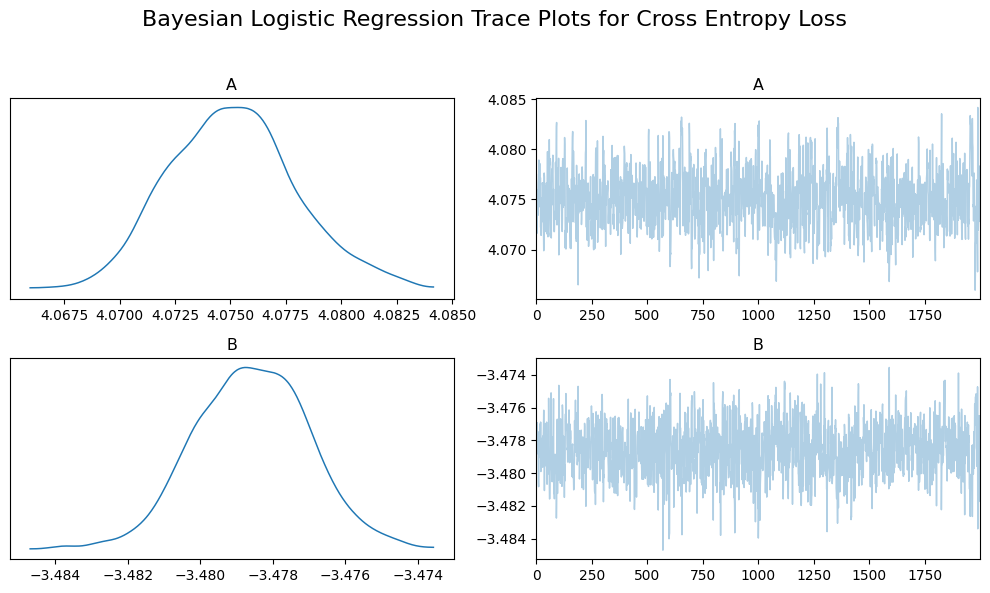

In [30]:
# 1) Extract posterior draws from your MCMC object
posterior = mcmc.get_samples()    # these are JAX DeviceArrays on GPU

# 2) Move A and B to NumPy on the host
A_np = np.asarray(posterior["A"])  # shape (n_samples,)
B_np = np.asarray(posterior["B"])

# 3) Create an ArviZ InferenceData from a Python dict
idata = az.from_dict(posterior={"A": A_np, "B": B_np})

# 4) Plot the trace
axes = az.plot_trace(idata, var_names=["A", "B"], figsize=(10, 6))

# 5) Add a super‐title and tighten layout
plt.suptitle("Bayesian Logistic Regression Trace Plots for Cross Entropy Loss", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [31]:
A_hat = np.mean(A_np)
B_hat = np.mean(B_np)

In [32]:
p_hat = 1/(1 + np.exp(-(A_hat * z_test + B_hat)))

In [33]:
p_hat = p_hat.reshape(N,H,W)

In [34]:
p_hat.shape

(16, 768, 1152)

In [35]:
predicted_mask = p_hat > 0.5

In [36]:
true_mask = gt[:,0,:,:].cpu()>0

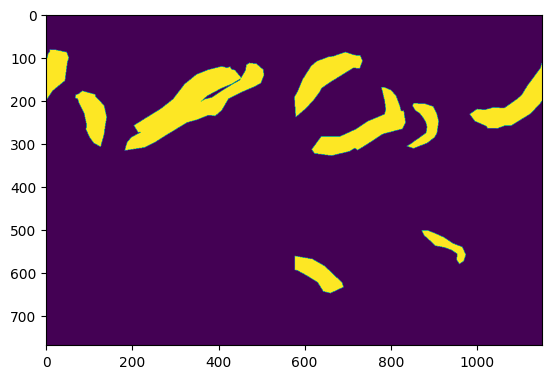

In [37]:
plt.imshow(true_mask[3,:,:])

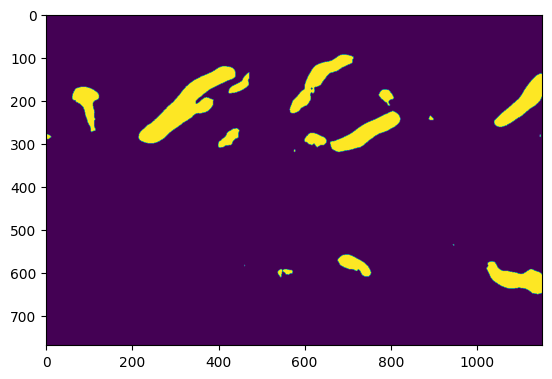

In [38]:
plt.imshow(predicted_mask[3,:,:])


In [39]:
# Assuming true_mask has shape (61, 1, 768, 1152)
# and predicted_mask has shape (61, 768, 1152) (adjust indexing if needed)
num_samples = true_mask.shape[0]
scores = []

for i in range(num_samples):
    # Flatten the true mask and predicted mask for each sample.
    true_flat = true_mask[i, :, :].ravel()    # shape (768*1152,)
    pred_flat = predicted_mask[i, :, :].ravel()  # shape (768*1152,)
    pred_flat = pred_flat.ravel()
    
    # Compute the Jaccard score for the binary classification
    score = jaccard_score(true_flat, pred_flat)
    scores.append(score)

# Compute the average Jaccard score across all samples
average_jaccard = np.mean(scores)
print("Average Jaccard Score:", average_jaccard)

Average Jaccard Score: 0.39764704948412455


In [33]:
predicted_mask.shape

(16, 768, 1152)

In [14]:
# ------------------------------------------------------------
#  Plot TMQ · y_cons · SegNet probability   for every test slice
# ------------------------------------------------------------
import torch, matplotlib.pyplot as plt, pathlib
from tqdm import tqdm



# -------- user-editable paths ----------------------------------------------
weights   = "/home/sbk29/data/github_AR/AR_detection/u-net/runs/arseg/segnet_final.pt"          # trained weights (.pt)
data_dir  = "/home/sbk29/data/AR/test"      # folder with .nc test files
out_dir   = pathlib.Path("plots").expanduser()
batch_size = 1
device     = "cuda" if torch.cuda.is_available() else "cpu"
# ---------------------------------------------------------------------------

@torch.no_grad()
def plot_all(weights, data_dir, out_dir, batch_size=1, device="cuda"):
    ds = ARMultiAnnDataset(data_dir, ["TMQ"])            # dataset returns x_vars, y_list, y_cons
    dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False,
                                     collate_fn=collate_var, pin_memory=(device=="cuda"))

    seg = SegNet().to(device).eval()
    seg.load_state_dict(torch.load(weights, map_location=device))

    out_dir.mkdir(parents=True, exist_ok=True)

    for (x_vars, _, y_cons), (date_key, _) in tqdm(zip(dl, ds.samples),
                                                  total=len(ds), ncols=80):
        x_vars = x_vars.to(device)                  # [B,1,H,W]
        prob   = torch.sigmoid(seg(x_vars))[0, 0].cpu()   # (H,W)
        tmq    = x_vars[0, 0].cpu()
        cons   = y_cons[0, 0]                       # (H,W) float

        fig, ax = plt.subplots(1, 3, figsize=(11, 3.5))
        ax[0].imshow(tmq,  cmap="viridis"); ax[0].set_title("TMQ");          ax[0].axis("off")
        ax[1].imshow(cons, cmap="magma",  vmin=0, vmax=1); ax[1].set_title("y_Consolidated"); ax[1].axis("off")
        ax[2].imshow(prob, cmap="magma",  vmin=0, vmax=1); ax[2].set_title("U-Net prob"); ax[2].axis("off")

        fig.suptitle(f"Date: {date_key}", fontsize=13)
        fig.tight_layout()
        fig.savefig(out_dir / f"{date_key}.png", dpi=120)
        plt.close(fig)

    print("Saved plots to:", out_dir.resolve())

# -------- run ----------------------------------------------------------------
plot_all(weights, data_dir, out_dir, batch_size, device)


/tmp/ipykernel_1590872/443872827.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  seg.load_state_dict(torch.load(weights, map_location=device))
100%|████████████████████

Saved plots to: /mnt/pixstor/data/sbk29/github_AR/AR_detection/u-net/plots


In [18]:


# --------- user-editable paths ------------------------------------------------
weights   = "/home/sbk29/data/github_AR/AR_detection/u-net/runs/arseg/segnet_final.pt" 
data_dir  = "/home/sbk29/data/AR/test"
out_dir   = pathlib.Path("plots_with_bg")
bg_img_path = "/home/sbk29/data/github_AR/AR_detection/climatenet/bluemarble/BM.jpeg"   # must match TMQ resolution
batch_size = 1
device     = "cuda" if torch.cuda.is_available() else "cpu"
# ------------------------------------------------------------------------------

@torch.no_grad()
def plot_all(weights, data_dir, out_dir, bg_img_path, batch_size=1, device="cuda"):
    ds = ARMultiAnnDataset(data_dir, ["TMQ"])
    dl = torch.utils.data.DataLoader(ds, batch_size=batch_size, shuffle=False,
                                     collate_fn=collate_var, pin_memory=(device=="cuda"))

    seg = SegNet().to(device).eval()
    seg.load_state_dict(torch.load(weights, map_location=device))

    bg = mpimg.imread(bg_img_path)   # should be (768, 1152[, 3])
    out_dir.mkdir(parents=True, exist_ok=True)

    for (x_vars, _, y_cons), (date_key, _) in tqdm(zip(dl, ds.samples), total=len(ds), ncols=80):
        x_vars = x_vars.to(device)
        prob   = torch.sigmoid(seg(x_vars))[0, 0].cpu()
        tmq    = x_vars[0, 0].cpu()
        cons   = y_cons[0, 0]

        fig, ax = plt.subplots(1, 3, figsize=(15, 4))

        # --- TMQ: standalone + colorbar
        im0 = ax[0].imshow(tmq, cmap="viridis")
        c0 = fig.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)
        c0.set_label("TMQ")
        ax[0].set_title("TMQ"); ax[0].axis("off")

        # --- y_cons overlaid on background
        ax[1].imshow(bg, cmap='gray', alpha=1.0)
        im1 = ax[1].imshow(cons, cmap="magma", vmin=0, vmax=1, alpha=0.6)
        c1 = fig.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)
        c1.set_label("y_cons")
        ax[1].set_title("y_cons"); ax[1].axis("off")

        # --- prediction overlaid on background
        ax[2].imshow(bg, cmap='gray', alpha=1.0)
        im2 = ax[2].imshow(prob, cmap="magma", vmin=0, vmax=1, alpha=0.6)
        c2 = fig.colorbar(im2, ax=ax[2], fraction=0.046, pad=0.04)
        c2.set_label("prob")
        ax[2].set_title("SegNet prob"); ax[2].axis("off")

        fig.suptitle(f"Date: {date_key}", fontsize=13)
        fig.tight_layout()
        fig.savefig(out_dir / f"{date_key}.png", dpi=120)
        plt.close(fig)

    print("✅ Saved plots to:", out_dir.resolve())

# ---------- Run it -------------------
plot_all(weights, data_dir, out_dir, bg_img_path, batch_size, device)


/tmp/ipykernel_1590872/3008682495.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  seg.load_state_dict(torch.load(weights, map_location=device))
100%|███████████████████

✅ Saved plots to: /mnt/pixstor/data/sbk29/github_AR/AR_detection/u-net/plots_with_bg


In [6]:
from procrustes_loss_new import ProcrustesLossBag

In [17]:


# ---------- CONFIG ---------------------------------------------------
data_dir = "/home/sbk29/data/AR/train"
var_names = ["TMQ"]
batch_size = 8
device = "cuda" if torch.cuda.is_available() else "cpu"

# ---------- LOAD DATA ------------------------------------------------
ds = ARMultiAnnDataset(data_dir, var_names)
loader = torch.utils.data.DataLoader(ds, batch_size=batch_size,
                                     shuffle=True, collate_fn=collate_var)

# ---------- INIT LOSS ------------------------------------------------
loss_fn = ProcrustesLossBag(alpha=2.0)

# ---------- FETCH A BATCH --------------------------------------------
x_vars, y_lists, y_cons = next(iter(loader))

# To GPU (only x and y_cons for sanity)
x_vars = x_vars.to(device)
y_cons = y_cons.to(device)

# Dummy prediction (simulate a trained model output)
logits = torch.rand_like(y_cons) * 5 - 2.5   # logits in range [-2.5, 2.5]
probs = torch.sigmoid(logits)

# ---------- COMPUTE LOSS ---------------------------------------------
loss = loss_fn(probs, y_cons)

# # ---------- VISUALIZE ------------------------------------------------
# import pandas as pd
# import ace_tools as tools

# # Show sample stats
# sample_stats = []
# for i in range(batch_size):
#     stats = {
#         "Index": i,
#         "y_cons min": float(y_cons[i,0].min()),
#         "y_cons max": float(y_cons[i,0].max()),
#         "prob min": float(probs[i,0].min()),
#         "prob max": float(probs[i,0].max()),
#     }
#     sample_stats.append(stats)

# df = pd.DataFrame(sample_stats)
# tools.display_dataframe_to_user(name="Sample Sanity Check", dataframe=df)

# Also return loss value
loss.item()


11146.603515625

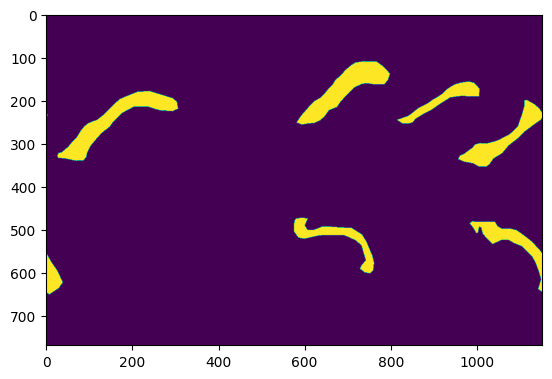

In [13]:
plt.imshow(y_cons[1,0,:,:].cpu())

In [15]:
loss

tensor(9540.6045, device='cuda:0')